### Setup

In [28]:
!./venv/bin/pip install kaggle pandas matplotlib seaborn numpy scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 2.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.9/28.9 MB 2.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


#### Imports

In [81]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Options

In [2]:
pd.set_option('display.expand_frame_repr', False)

### Data Collection

In [21]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
train_df = pd.read_csv("train.csv")
print(train_df.describe())
train_df

       PassengerId    Survived      Pclass         Age       SibSp       Parch        Fare
count   891.000000  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std     257.353842    0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min       1.000000    0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%     446.000000    0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%     668.500000    1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Cleaning the Data

Counting any null values

In [5]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Survival & Passenger Class Count

/Users/maxim/Documents/work/sigmoid_hw/04_Logistic_Regression/venv/lib/python3.13/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


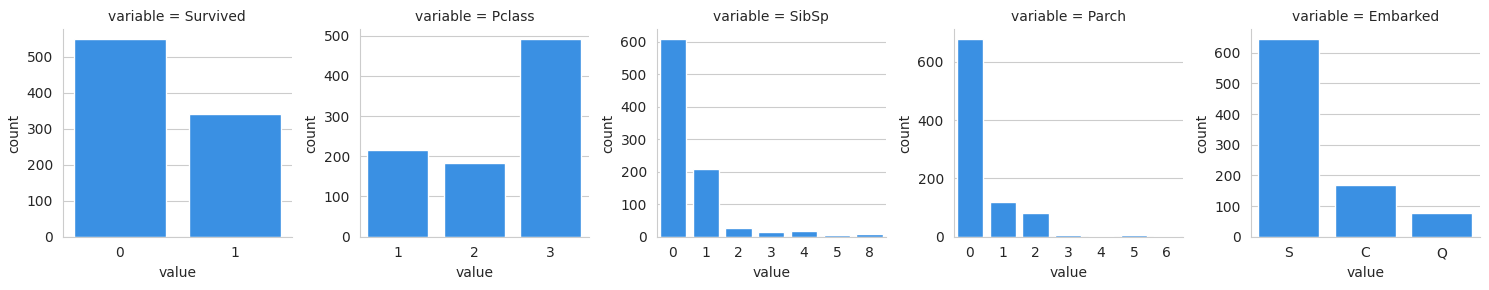

In [ ]:
count_cols = ["Survived", "Pclass", "SibSp", "Parch", "Embarked"]
with sns.axes_style('whitegrid'):
  nd = pd.melt(train_df, value_vars=count_cols)
  n1 = sns.FacetGrid(nd, col='variable', col_wrap=5, sharex=False, sharey=False)
  n1 = n1.map(sns.countplot, 'value', color='#1e90ff')


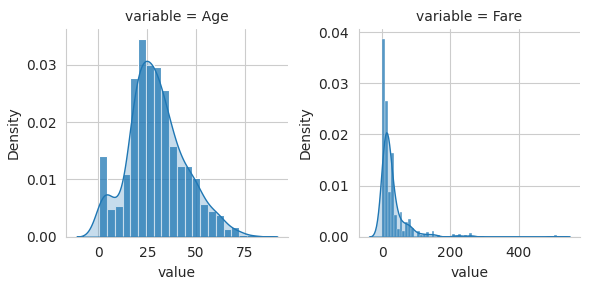

In [ ]:
kde_cols = ["Age", "Fare"]

with sns.axes_style('whitegrid'):
  nd = pd.melt(train_df, value_vars=kde_cols)
  n1 = sns.FacetGrid(nd, col='variable', col_wrap=2, sharex=False, sharey=False)

  n1.map(
      sns.histplot,
      'value',
      stat='density',
  )

  n1.map(
      sns.kdeplot,
      'value',
      fill=True
  )

#### Convert Categorical Columns

In [6]:
def convert_categorical(df):
    cat_df = df.copy()
    cat_df["Sex"] = cat_df["Sex"].map({"male": 0, "female": 1})
    cat_df["Embarked_S"] = cat_df["Embarked"] == "S"
    cat_df["Embarked_S"] = cat_df["Embarked_S"].astype(int)

    return cat_df

In [7]:
clean_df = convert_categorical(train_df)

clean_df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.722783
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.447876
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000


#### Estimating missing age values

In [89]:
def prepare_imputer_df(df):
    return df.copy().drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Embarked", "Survived"], errors="ignore")

def fit_imputer(df):
    imputer = IterativeImputer(max_iter=10, random_state=42)

    imputer_df = prepare_imputer_df(df)
    imputer_df[:] = imputer.fit_transform(imputer_df)

    return imputer

def postprocess_imputer(df):
    df["Age"] = df["Age"].clip(lower=0, upper=80)
    

In [94]:
simplified_df = prepare_imputer_df(clean_df)
test_imputer = fit_imputer(simplified_df)
simplified_df[:] = test_imputer.transform(simplified_df)
postprocess_imputer(simplified_df)

age_df = pd.DataFrame({"Age_estimated": simplified_df["Age"], "Age": clean_df["Age"]})

age_df.describe()

,Age_estimated,Age
count,891.000000,714.000000
mean,0.338898,0.000000
std,0.592884,1.000701
min,0.000000,-2.016979
25%,0.000000,-0.659542
50%,0.000000,-0.117049
75%,0.434055,0.571831
max,3.465126,3.465126


Newly predicted age values are behaving similarly to the original training dataset

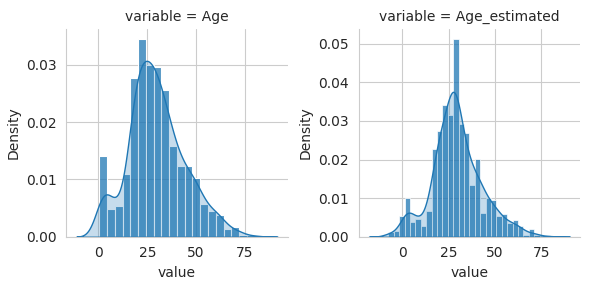

In [16]:
age_cols = ["Age", "Age_estimated"]

with sns.axes_style('whitegrid'):
  nd = pd.melt(age_df, value_vars=age_cols)
  n1 = sns.FacetGrid(nd, col='variable', col_wrap=2, sharex=False, sharey=False)

  n1.map(
      sns.histplot,
      'value',
      stat='density',
  )

  n1.map(
      sns.kdeplot,
      'value',
      fill=True
  )

Applying age estimate to dataset

In [15]:
def apply_age_estimate(df, imputer):
    df = df.copy()
    df[:] = imputer.transform(df)
    postprocess_imputer(df)

    return df["Age"]

In [ ]:
# clean_df["Age"] = apply_age_estimate(clean_df)

     Pclass  Sex        Age  SibSp  Parch     Fare  Embarked_S
0         3    0  22.000000      1      0   7.2500           1
1         1    1  38.000000      1      0  71.2833           0
2         3    1  26.000000      0      0   7.9250           1
3         1    1  35.000000      1      0  53.1000           1
4         3    0  35.000000      0      0   8.0500           1
..      ...  ...        ...    ...    ...      ...         ...
886       2    0  27.000000      0      0  13.0000           1
887       1    1  19.000000      0      0  30.0000           1
888       3    1  19.856925      1      2  23.4500           1
889       1    0  26.000000      0      0  30.0000           0
890       3    0  32.000000      0      0   7.7500           0

[891 rows x 7 columns]


Dropping Unnecessary Columns

In [16]:
columns_to_drop = ["Ticket", "PassengerId", "Name", "Cabin", "Embarked"]

def drop_extra_cols(df):
    return df.drop(columns=columns_to_drop, errors="ignore")

In [17]:
clean_df = drop_extra_cols(clean_df)

#### Normalize Values

In [18]:
num_cols = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

scaler_X = StandardScaler()
clean_df[num_cols] = scaler_X.fit_transform(clean_df[num_cols])

#### Final Clean DataFrame

In [19]:
print(clean_df)
clean_df.describe()

     Survived    Pclass  Sex       Age     SibSp     Parch      Fare  Embarked_S
0           0  0.827377    0 -0.530377  0.432793 -0.473674 -0.502445           1
1           1 -1.566107    1  0.571831  0.432793 -0.473674  0.786845           0
2           1  0.827377    1 -0.254825 -0.474545 -0.473674 -0.488854           1
3           1 -1.566107    1  0.365167  0.432793 -0.473674  0.420730           1
4           0  0.827377    0  0.365167 -0.474545 -0.473674 -0.486337           1
..        ...       ...  ...       ...       ...       ...       ...         ...
886         0 -0.369365    0 -0.185937 -0.474545 -0.473674 -0.386671           1
887         1 -1.566107    1 -0.737041 -0.474545 -0.473674 -0.044381           1
888         0  0.827377    1       NaN  0.432793  2.008933 -0.176263           1
889         1 -1.566107    0 -0.254825 -0.474545 -0.473674 -0.044381           0
890         0  0.827377    0  0.158503 -0.474545 -0.473674 -0.492378           0

[891 rows x 8 columns]


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_S
count,891.000000,8.910000e+02,891.000000,714.000000,8.910000e+02,8.910000e+02,8.910000e+02,891.000000
mean,0.383838,4.386066e-17,0.352413,0.000000,1.594933e-17,5.283216e-17,3.987333e-18,0.722783
std,0.486592,1.000562e+00,0.477990,1.000701,1.000562e+00,1.000562e+00,1.000562e+00,0.447876
min,0.000000,-1.566107e+00,0.000000,-2.016979,-4.745452e-01,-4.736736e-01,-6.484217e-01,0.000000
25%,0.000000,-3.693648e-01,0.000000,-0.659542,-4.745452e-01,-4.736736e-01,-4.891482e-01,0.000000
50%,0.000000,8.273772e-01,0.000000,-0.117049,-4.745452e-01,-4.736736e-01,-3.573909e-01,1.000000
75%,1.000000,8.273772e-01,1.000000,0.571831,4.327934e-01,-4.736736e-01,-2.424635e-02,1.000000
max,1.000000,8.273772e-01,1.000000,3.465126,6.784163e+00,6.974147e+00,9.667167e+00,1.000000


### Feature Engineering

#### Survival Rate vs Deck

In [108]:
df = train_df.copy()

df["Deck"] = df["Cabin"].fillna("Unknown").astype(str).str[0]

deck_stats = (
    df.groupby("Deck")["Survived"]
      .agg(survival_rate="mean", n="size")
      .sort_values(["survival_rate", "n"], ascending=[False, False])
)

deck_stats

,survival_rate,n
Deck,,
D,0.757576,33
E,0.750000,32
B,0.744681,47
F,0.615385,13
C,0.593220,59
G,0.500000,4
A,0.466667,15
U,0.299854,687
T,0.000000,1


In [45]:
# "U" for Unknown
non_favourable_decks = ["A", "U", "T"]

deck_type = train_df["Cabin"].fillna("Unknown").astype(str).str[0]
clean_df["Deck_Type"] = [0 if deck in non_favourable_decks else 1 for deck in deck_type]

#### Determining Married Couples

Usually, married women were listed under their husband names, and their real names were added afterwards. This is a clue to whether or not they survived the accident.

In [72]:
names = train_df["Name"].astype(str).str[:]
clean_df["With_Nickname"] = ["(" in name or "\"" in name for name in names]
clean_df["With_Nickname"] = clean_df["With_Nickname"].astype(int)

#### Dataset Correlation

            Survived    Pclass       Sex       Age     SibSp     Parch      Fare  Embarked_S
Survived    1.000000 -0.338481  0.543351 -0.077221 -0.035322  0.081629  0.257307   -0.155660
Pclass     -0.338481  1.000000 -0.131900 -0.369226  0.083081  0.018443 -0.549500    0.081720
Sex         0.543351 -0.131900  1.000000 -0.093254  0.114631  0.245489  0.182333   -0.125722
Age        -0.077221 -0.369226 -0.093254  1.000000 -0.308247 -0.189119  0.096067   -0.032523
SibSp      -0.035322  0.083081  0.114631 -0.308247  1.000000  0.414838  0.159651    0.070941
Parch       0.081629  0.018443  0.245489 -0.189119  0.414838  1.000000  0.216225    0.063036
Fare        0.257307 -0.549500  0.182333  0.096067  0.159651  0.216225  1.000000   -0.166603
Embarked_S -0.155660  0.081720 -0.125722 -0.032523  0.070941  0.063036 -0.166603    1.000000


<Axes: >

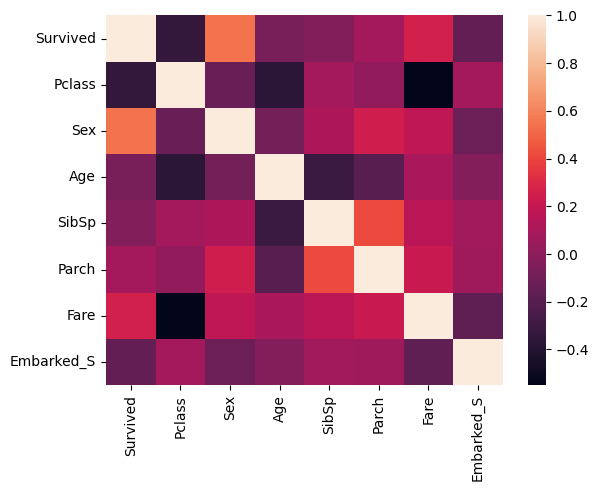

In [41]:
corr = clean_df.corr()

print(corr)
sns.heatmap(corr)

Filter columns by correlation

In [74]:
THRESHOLD = 0.05

survive_correlations = corr["Survived"].drop("Survived")

training_cols = survive_correlations.loc[lambda x: abs(x) > THRESHOLD]

training_cols.keys()

Index(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked_S'], dtype='object')

### Data Splitting

In [97]:
X = clean_df[training_cols.keys()]
y = clean_df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

if "Age" in X.keys():
    print("Includes age column, predicting the missing ages")
    imputer = fit_imputer(X_train)
    X_train["Age"] = apply_age_estimate(X_train, imputer)
    postprocess_imputer(X_train)

    X_test["Age"] = apply_age_estimate(X_test, imputer)
    postprocess_imputer(X_test)


Includes age column, predicting the missing ages


In [87]:
X_train.describe()

,Pclass,Sex,Age,Parch,Fare,Embarked_S
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.025627,0.344101,0.329798,-0.002955,0.007693,0.737360
std,0.986815,0.475408,0.582443,0.982702,1.046390,0.440378
min,-1.566107,0.000000,0.000000,-0.473674,-0.648422,0.000000
25%,-0.369365,0.000000,0.000000,-0.473674,-0.488854,0.000000
50%,0.827377,0.000000,0.000000,-0.473674,-0.357391,1.000000
75%,0.827377,1.000000,0.434055,-0.473674,-0.034314,1.000000
max,0.827377,1.000000,3.465126,6.974147,9.667167,1.000000


In [96]:
X_train.isna().sum()

Pclass        0
Sex           0
Age           0
Parch         0
Fare          0
Embarked_S    0
dtype: int64

In [77]:
X_test.describe()

,Pclass,Sex,Age,Parch,Fare,Embarked_S
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,-0.101936,0.385475,0.366625,0.011752,-0.030599,0.664804
std,1.050142,0.488073,0.629722,1.071474,0.794268,0.473383
min,-1.566107,0.000000,0.000000,-0.473674,-0.648422,0.000000
25%,-1.566107,0.000000,0.000000,-0.473674,-0.489442,0.000000
50%,0.827377,0.000000,0.000000,-0.473674,-0.356469,1.000000
75%,0.827377,1.000000,0.543334,-0.473674,0.004152,1.000000
max,0.827377,1.000000,2.845134,5.732844,4.634417,1.000000


### Model Training

#### Training

In [78]:
clf = LogisticRegression(random_state=42)

clf.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

#### Performance Evaluation

In [79]:
y_pred = clf.predict(X_test)

Confusion Matrix

In [80]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel().tolist()

print("Confusion matrix:")
print(f"[{tn}, {fp}]")
print(f"[{fn}, {tp}]")

total = tn + fp + fn + tp
print(f"Correctly classified: {(tn + tp) / total}")
print(f"Falsely classified: {(fn + fp) / total}")

Confusion matrix:
[89, 16]
[20, 54]
Correctly classified: 0.7988826815642458
Falsely classified: 0.2011173184357542


Examples of false 

Sex has the most correlation to the survival rate, which is shown in the false results below

Females (sex = 1) were more likely to survive, so they are more susceptible to be marked as survived

In [85]:
false_positives = np.logical_and(y_test != y_pred, y_pred == 1)

X_test[false_positives][:5]

,Pclass,Sex,Age,Parch,Fare,Embarked_S
485,0.827377,1,0.000000,0.767630,-0.135658,1
396,0.827377,1,0.089615,-0.473674,-0.490280,1
793,-1.566107,0,0.663977,-0.473674,-0.030371,0
235,0.827377,1,0.000000,-0.473674,-0.496405,1
362,0.827377,1,1.054047,0.767630,-0.357391,0


On the other hand, males (sex = 0) were more likely to not survive, which causes the false negatives

In [95]:
false_negatives = np.logical_and(y_test != y_pred, y_pred == 0)

X_test[false_negatives][:5]

,Pclass,Sex,Age,Parch,Fare,Embarked_S
709,0.827377,0,0.000000,0.767630,-0.341452,0
621,-1.566107,0,0.847383,-0.473674,0.409741,1
447,-1.566107,0,0.296279,-0.473674,-0.113846,1
673,-0.369365,0,0.089615,-0.473674,-0.386671,1
204,0.827377,0,0.000000,-0.473674,-0.486337,1
